In [ ]:
# from google.colab import files
# uploaded = files.upload()


In [ ]:
# import zipfile
# import os

# with zipfile.ZipFile("data.zip", 'r') as zip_ref:
#   zip_ref.extractall("data")


In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Z skalowaniem

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels= 1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_data = datasets.ImageFolder(
    root="data/data/split/train",
    transform=transform
)

test_data = datasets.ImageFolder(
    root="data/data/split/test",
    transform= transform
)

image, label = train_data[0]
print(image, label)
print(image.shape)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]) 0
torch.Size([1, 128, 128])


In [ ]:
names_of_classes = train_data.classes

In [ ]:
train_data.class_to_idx

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [ ]:
from collections import Counter

# Dla zbioru treningowego
train_counts = Counter([label for _, label in train_data])

print(" Liczba obrazów w każdej klasie (TRAIN):")
for cls, idx in train_data.class_to_idx.items():
    print(f"{cls}: {train_counts[idx]}")

# Dla zbioru testowego
test_counts = Counter([label for _, label in test_data])

print("\n Liczba obrazów w każdej klasie (TEST):")
for cls, idx in test_data.class_to_idx.items():
    print(f"{cls}: {test_counts[idx]}")



📊 Liczba obrazów w każdej klasie (TRAIN):
MildDemented: 716
ModerateDemented: 51
NonDemented: 2560
VeryMildDemented: 1792

📊 Liczba obrazów w każdej klasie (TEST):
MildDemented: 180
ModerateDemented: 13
NonDemented: 640
VeryMildDemented: 448


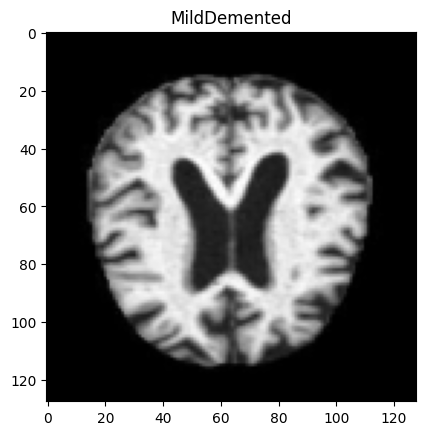

In [ ]:
image, label = train_data[0]
plt.title(label)
plt.title(names_of_classes[label])
plt.imshow(image.squeeze(), cmap='gray')

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = 32,
    shuffle = False
)

print(f"Length of train dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

image, label = train_data[0]
print(image.shape)
print(label)

image_batch, label_batch = next(iter(train_dataloader))
print(image_batch.shape)
print(label_batch)

Length of train dataloader: 160
Length of test dataloader: 41
torch.Size([1, 128, 128])
0
torch.Size([32, 1, 128, 128])
tensor([2, 0, 3, 2, 3, 2, 0, 3, 0, 2, 2, 3, 2, 3, 3, 2, 3, 0, 2, 3, 2, 2, 3, 2,
        3, 2, 3, 3, 0, 3, 2, 3])


In [ ]:
class EarlyStopper:
    """Monitoruje stratę walidacyjną i zatrzymuje trening, gdy poprawa ustaje."""
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.should_stop = False
        self.best_model_state = None

    def __call__(self, validation_loss, model):
        # Sprawdzanie, czy strata się pogorszyła
        if validation_loss > self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        # Sprawdzanie, czy nastąpiła poprawa
        else:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Zapis stanu modelu tylko przy najlepszym wyniku
            self.best_model_state = model.state_dict()

        return self.should_stop

    def load_best_weights(self, model):
        """Ładuje najlepsze wagi znalezione przed zatrzymaniem."""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            return True
        return False

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


    from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):

    model.to(device)
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
def train(model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test(model: nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         accuracy_fn,
         device: torch.device = device
         ):

  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_test_pred = model(X)

      test_loss += loss_fn(y_test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=y_test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
class ModelV2CNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
     super().__init__()
     self.block1 = nn.Sequential(
         nn.Conv2d(in_channels=input_shape,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.MaxPool2d(kernel_size=2, stride=2)
     )
     self.block2 = nn.Sequential(
         nn.Conv2d(in_channels=hidden_units,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.Conv2d(in_channels=hidden_units,
                   out_channels=hidden_units,
                   kernel_size=3,
                   stride=1,
                   padding=1),
         nn.ReLU(),
         nn.MaxPool2d(kernel_size=2, stride=2)
     )
     self.classifier = nn.Sequential(
         nn.Flatten(),
         nn.Linear(in_features=hidden_units*32*32,
                   out_features= output_shape)
     )

  def forward(self, x: torch.Tensor):
    x = self.block1(x)
    #print(x.shape)
    x = self.block2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

torch.manual_seed(42)
modelV2 = ModelV2CNN(input_shape=1,
                     hidden_units=64,
                     output_shape=len(names_of_classes)).to(device)

modelV2

ModelV2CNN(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelV2.parameters(), lr=0.01)

In [ ]:
for images, labels in train_dataloader:
    images = images.to(device)
    outputs = modelV2(images)
    break


In [ ]:
torch.manual_seed(42)
from tqdm import tqdm
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train(data_loader=train_dataloader,
        model=modelV2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test(data_loader=test_dataloader,
        model=modelV2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.03391 | Train accuracy: 49.62%


 10%|█         | 1/10 [00:11<01:43, 11.46s/it]

Test loss: 0.98018 | Test accuracy: 51.22%

Epoch: 1
---------
Train loss: 0.97811 | Train accuracy: 52.06%


 20%|██        | 2/10 [00:22<01:29, 11.14s/it]

Test loss: 0.98814 | Test accuracy: 49.24%

Epoch: 2
---------
Train loss: 0.94575 | Train accuracy: 54.01%


 30%|███       | 3/10 [00:33<01:17, 11.02s/it]

Test loss: 0.92064 | Test accuracy: 52.21%

Epoch: 3
---------
Train loss: 0.91864 | Train accuracy: 55.34%


 40%|████      | 4/10 [00:44<01:05, 10.99s/it]

Test loss: 0.87927 | Test accuracy: 59.22%

Epoch: 4
---------
Train loss: 0.89022 | Train accuracy: 57.82%


 50%|█████     | 5/10 [00:54<00:54, 10.85s/it]

Test loss: 0.85385 | Test accuracy: 59.53%

Epoch: 5
---------
Train loss: 0.86199 | Train accuracy: 59.95%


 60%|██████    | 6/10 [01:05<00:43, 10.82s/it]

Test loss: 0.83937 | Test accuracy: 58.92%

Epoch: 6
---------
Train loss: 0.81648 | Train accuracy: 62.80%


 70%|███████   | 7/10 [01:16<00:32, 10.87s/it]

Test loss: 0.78291 | Test accuracy: 65.78%

Epoch: 7
---------
Train loss: 0.78035 | Train accuracy: 64.97%


 80%|████████  | 8/10 [01:27<00:22, 11.01s/it]

Test loss: 0.91008 | Test accuracy: 57.24%

Epoch: 8
---------
Train loss: 0.74470 | Train accuracy: 66.62%


 90%|█████████ | 9/10 [01:38<00:11, 11.01s/it]

Test loss: 0.70603 | Test accuracy: 69.97%

Epoch: 9
---------
Train loss: 0.68645 | Train accuracy: 70.62%


100%|██████████| 10/10 [01:49<00:00, 10.98s/it]

Test loss: 0.68377 | Test accuracy: 69.97%

Train time on cuda: 109.777 seconds


In [ ]:
results_of_model2 = eval_model(model=modelV2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn)
results_of_model2

{'model_name': 'ModelV2CNN',
 'model_loss': 0.6837666630744934,
 'model_acc': 69.96951219512195}

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import StratifiedKFold
from timeit import default_timer as timer
from tqdm.auto import tqdm
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.should_stop = False
        self.best_model_state = None

    def __call__(self, validation_loss, model):

        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0

            self.best_model_state = model.state_dict()

        elif validation_loss > self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

        return self.should_stop

    def load_best_weights(self, model):
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            return True
        return False


def train_epoch_hist(model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device):

    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc


def test_epoch_hist(model: nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         accuracy_fn,
         device: torch.device
         ):

  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_test_pred = model(X)

      test_loss += loss_fn(y_test_pred, y).item()
      test_acc += accuracy_fn(y_true=y, y_pred=y_test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    return test_loss, test_acc

def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn):
    loss, acc = test_epoch_hist(model, data_loader, loss_fn, accuracy_fn, next(model.parameters()).device)
    return {"model_loss": loss, "model_acc": acc}

def plot_confusion_matrix_subplot(y_true: np.ndarray,
                                  y_pred: np.ndarray,
                                  class_names: list,
                                  fold_num: int,
                                  ax):

    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    ax.set_title(f'Fold {fold_num}')
    ax.set_xlabel('Przewidziana Klasa')
    ax.set_ylabel('Rzeczywista Klasa')


def get_predictions_and_labels(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, device: torch.device):
    model.to(device)
    model.eval()
    y_pred_list = []
    y_true_list = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            y_pred_class = torch.argmax(y_logits, dim=1)

            y_pred_list.append(y_pred_class.cpu().numpy())
            y_true_list.append(y.cpu().numpy())

    y_pred_all = np.concatenate(y_pred_list)
    y_true_all = np.concatenate(y_true_list)
    return y_true_all, y_pred_all


from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

def calculate_advanced_metrics(y_true: np.ndarray, y_pred: np.ndarray, average_mode='weighted'):


    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average_mode, zero_division=0
    )

    accuracy = accuracy_score(y_true, y_pred)

    return {
        'Precision_W': precision * 100,
        'Recall_W': recall * 100,
        'F1_Score_W': fscore * 100,
        'model_acc': accuracy * 100
    }



Starting 5-Fold Stratified Cross-Validation on train_data with 100 epochs...
Pierwotny rozkład klas: Counter({np.int64(2): 2560, np.int64(3): 1792, np.int64(0): 716, np.int64(1): 51})

--- Fold 1/5 ---


Fold 1:   0%|          | 0/100 [00:00<?, ?it/s]


[EARLY STOPPING] Trening przerwany w epoce 41 z powodu braku poprawy.
Załadowano najlepsze wagi modelu z epoki o najniższej stracie walidacyjnej.
Total training time for Fold 1: 359.593 seconds
Fold 1 Final Validation Results: {'model_loss': 0.17540216595807578, 'model_acc': 94.921875, 'Precision_W': 94.93418236384517, 'Recall_W': 94.921875, 'F1_Score_W': 94.9126151553525, 'fold': 1, 'total_time': 359.59338994100017}

--- Fold 2/5 ---


Fold 2:   0%|          | 0/100 [00:00<?, ?it/s]


[EARLY STOPPING] Trening przerwany w epoce 43 z powodu braku poprawy.
Załadowano najlepsze wagi modelu z epoki o najniższej stracie walidacyjnej.
Total training time for Fold 2: 378.743 seconds
Fold 2 Final Validation Results: {'model_loss': 0.19748630574031267, 'model_acc': 94.921875, 'Precision_W': 94.91875377705342, 'Recall_W': 94.921875, 'F1_Score_W': 94.91834963655366, 'fold': 2, 'total_time': 378.7431345650002}

--- Fold 3/5 ---


Fold 3:   0%|          | 0/100 [00:00<?, ?it/s]


[EARLY STOPPING] Trening przerwany w epoce 34 z powodu braku poprawy.
Załadowano najlepsze wagi modelu z epoki o najniższej stracie walidacyjnej.
Total training time for Fold 3: 301.372 seconds
Fold 3 Final Validation Results: {'model_loss': 0.27306721318745986, 'model_acc': 92.87109375, 'Precision_W': 92.91509011340023, 'Recall_W': 92.87109375, 'F1_Score_W': 92.8566201319367, 'fold': 3, 'total_time': 301.371522079}

--- Fold 4/5 ---


Fold 4:   0%|          | 0/100 [00:00<?, ?it/s]


[EARLY STOPPING] Trening przerwany w epoce 42 z powodu braku poprawy.
Załadowano najlepsze wagi modelu z epoki o najniższej stracie walidacyjnej.
Total training time for Fold 4: 373.177 seconds
Fold 4 Final Validation Results: {'model_loss': 0.1539973799008294, 'model_acc': 94.43359375, 'Precision_W': 94.47966158859829, 'Recall_W': 94.43359375, 'F1_Score_W': 94.43865051531357, 'fold': 4, 'total_time': 373.17687191000005}

--- Fold 5/5 ---


Fold 5:   0%|          | 0/100 [00:00<?, ?it/s]


[EARLY STOPPING] Trening przerwany w epoce 41 z powodu braku poprawy.
Załadowano najlepsze wagi modelu z epoki o najniższej stracie walidacyjnej.
Total training time for Fold 5: 361.821 seconds
Fold 5 Final Validation Results: {'model_loss': 0.14766263297497062, 'model_acc': 96.28543499511241, 'Precision_W': 96.2893149712982, 'Recall_W': 96.28543499511241, 'F1_Score_W': 96.28689759868094, 'fold': 5, 'total_time': 361.82060925099995}


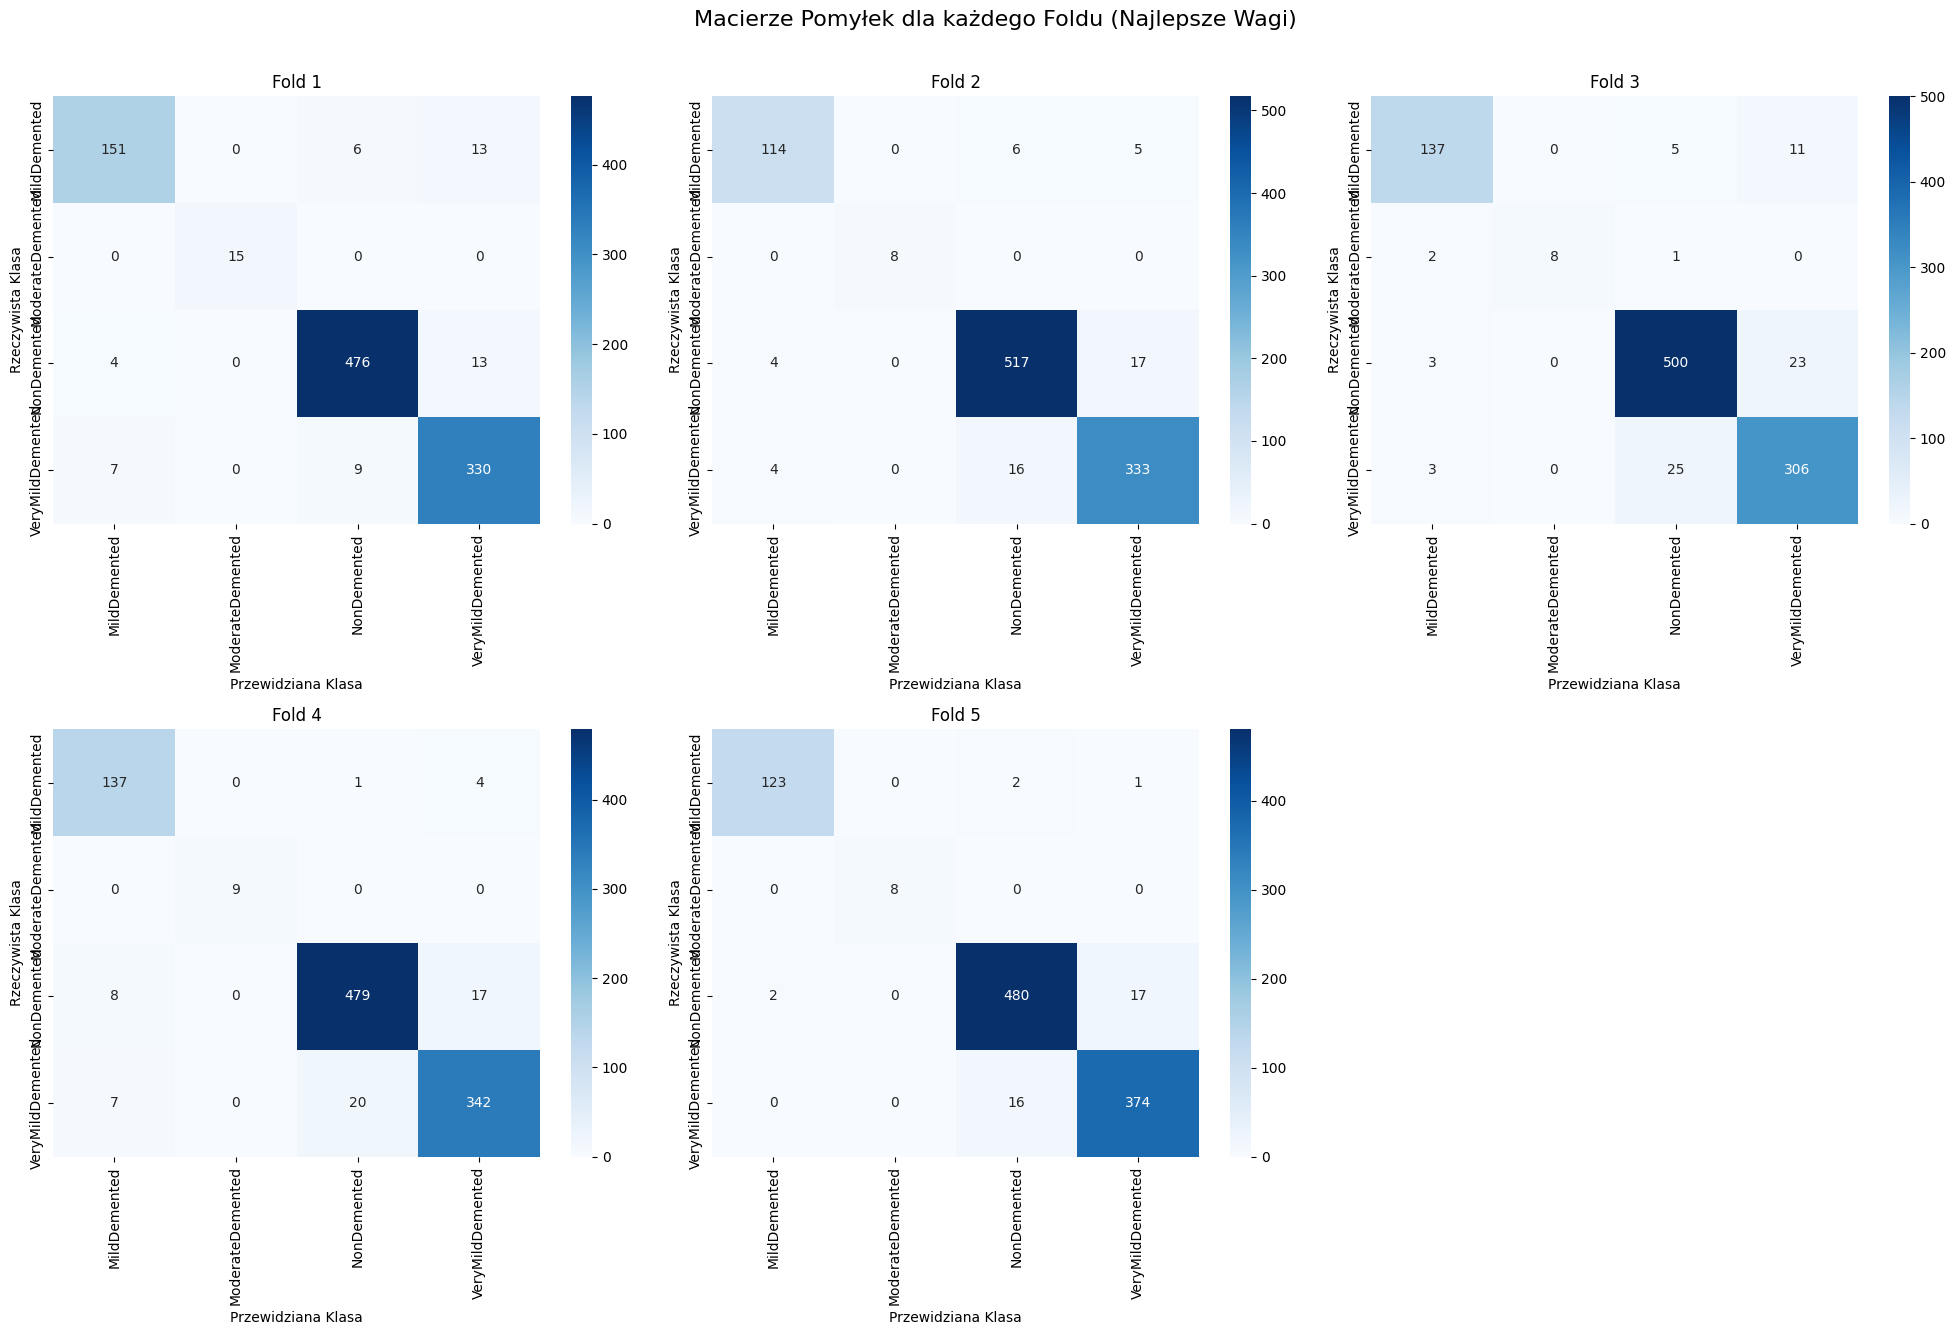

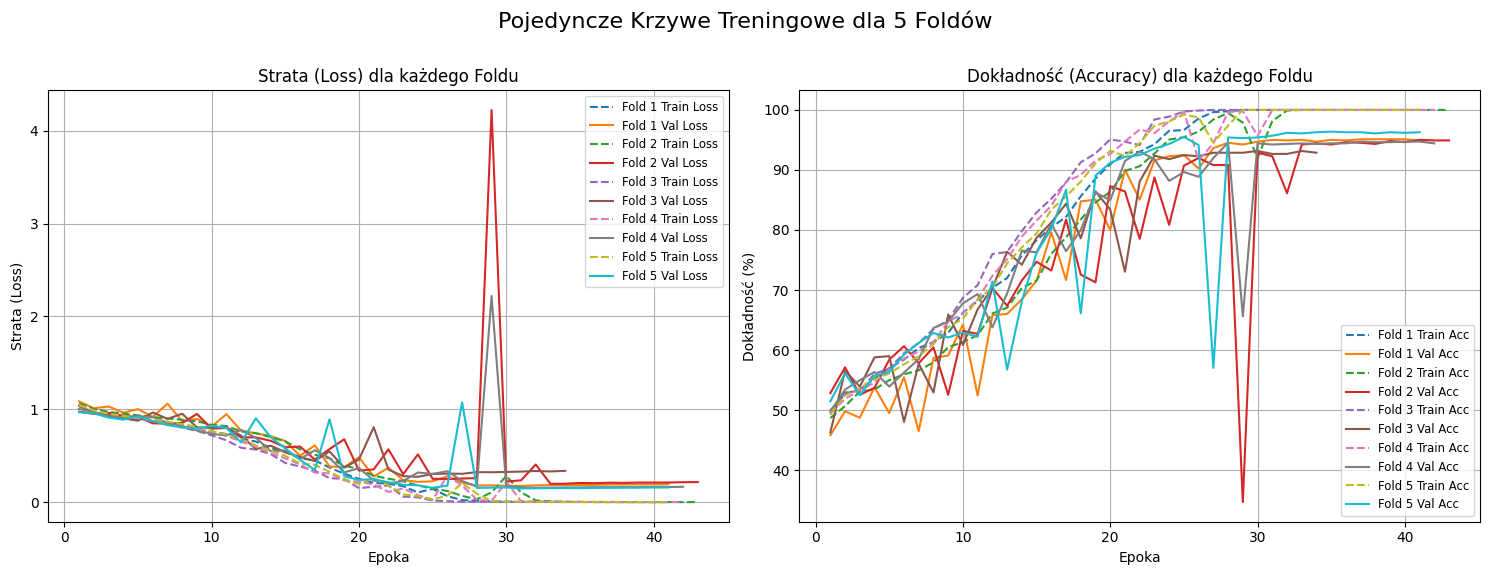

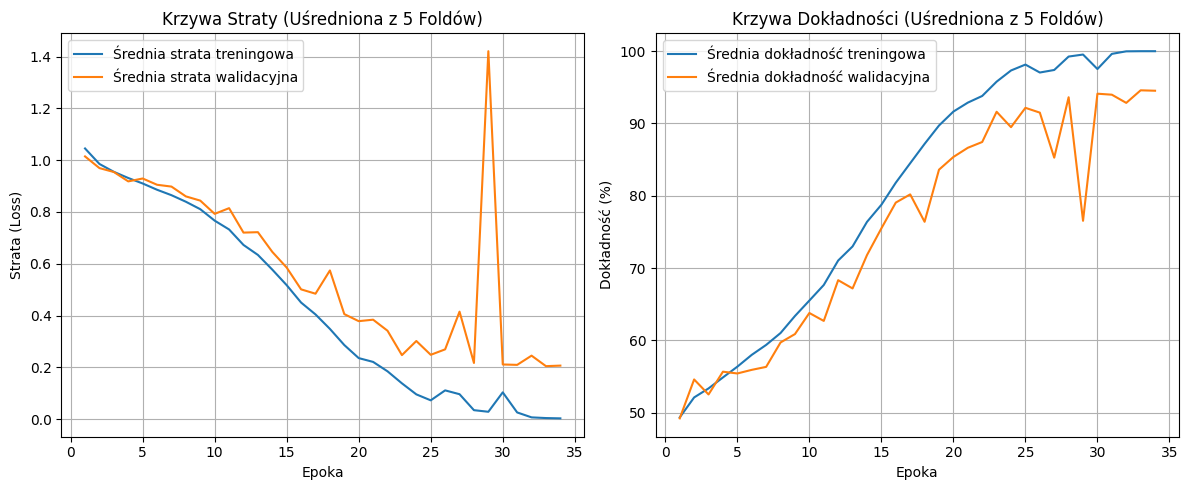


--- K-Fold Cross-Validation Finished ---

Average Results over 5 Folds:
Average Loss: 0.1895
Average Accuracy: 94.69%
Average Precision (Weighted): 94.71%
Average Recall (Weighted): 94.69%
Average F1-Score (Weighted): 94.68%
Average Training Time per Fold: 354.941s

--- Zapisywanie Indeksów i Klas Obrazów ---
 Pomyślnie zapisano listę przypisań obrazów do pliku: kfold_image_assignments.csv

Podgląd pierwszych 5 wierszy zapisanej tabeli:
 Fold   Set                                            Image_Identifier       Class_Name
    1 Train           data/split/train/NonDemented/NonDemented_0721.jpg      NonDemented
    1 Train           data/split/train/NonDemented/NonDemented_1660.jpg      NonDemented
    1 Train data/split/train/VeryMildDemented/VeryMildDemented_0714.jpg VeryMildDemented
    1 Train           data/split/train/NonDemented/NonDemented_1108.jpg      NonDemented
    1 Train data/split/train/VeryMildDemented/VeryMildDemented_0213.jpg VeryMildDemented

Czy każdy obraz trafił 

In [ ]:

# ==============================================================================
# 1. PRZYGOTOWANIE DANYCH I STRATIFIED K-FOLD
# ==============================================================================

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
class_counts = {0: 716, 1: 51, 2: 2560, 3: 1792}

simulated_data = []
for class_index, count in class_counts.items():
    class_name = class_names[class_index]
    for i in range(count):
        identifier = f"data/split/train/{class_name}/{class_name}_{i+1:04d}.jpg"
        simulated_data.append((identifier, class_index))

np.random.seed(42)
np.random.shuffle(simulated_data)

targets = np.array([item[1] for item in simulated_data])
num_samples = len(targets)
num_classes = len(class_names)
n_splits = 5
EPOCHS = 100

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
results_kfold = []
all_fold_details = []
history_kfold = []

print(f"Starting {n_splits}-Fold Stratified Cross-Validation on train_data with {EPOCHS} epochs...")
print(f"Pierwotny rozkład klas: {Counter(targets)}")

fig_cm, axes_cm = plt.subplots(2, 3, figsize=(20, 14))
axes_cm = axes_cm.flatten()


# ==============================================================================
# 2. GŁÓWNA PĘTLA K-FOLD (TRENING + EARLY STOPPING + MACIERZE Pomyłek) - WERSJA OSTATECZNA
# ==============================================================================

for fold, (train_index, val_index) in enumerate(skf.split(np.zeros(num_samples), targets)):
    fold_num = fold + 1
    print(f"\n--- Fold {fold_num}/{n_splits} ---")

    # A. Zapisywanie identyfikatorów
    for index in train_index:
        identifier, class_index = simulated_data[index]
        all_fold_details.append({'Fold': fold_num, 'Set': 'Train', 'Image_Identifier': identifier, 'Class_Name': class_names[class_index]})
    for index in val_index:
        identifier, class_index = simulated_data[index]
        all_fold_details.append({'Fold': fold_num, 'Set': 'Validation', 'Image_Identifier': identifier, 'Class_Name': class_names[class_index]})

    # B. Trening modelu
    train_subset = Subset(train_data, train_index)
    val_subset = Subset(train_data, val_index)

    train_fold_dataloader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_fold_dataloader = DataLoader(val_subset, batch_size=32, shuffle=False)

    torch.manual_seed(42 + fold)

    modelV2_fold = ModelV2CNN(input_shape=1, hidden_units=64, output_shape=num_classes).to(device)
    loss_fn_fold = nn.CrossEntropyLoss()
    optimizer_fold = optim.SGD(modelV2_fold.parameters(), lr=0.01)

    early_stopper = EarlyStopper(patience=10, min_delta=0.001)
    fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    train_time_start_fold = timer()

    for epoch in tqdm(range(EPOCHS), desc=f"Fold {fold_num}"):

        train_loss, train_acc = train_epoch_hist(
            data_loader=train_fold_dataloader, model=modelV2_fold, loss_fn=loss_fn_fold,
            optimizer=optimizer_fold, accuracy_fn=accuracy_fn, device=device)

        val_loss, val_acc = test_epoch_hist(
            data_loader=val_fold_dataloader, model=modelV2_fold, loss_fn=loss_fn_fold,
            accuracy_fn=accuracy_fn, device=device)

        fold_history['train_loss'].append(train_loss)
        fold_history['train_acc'].append(train_acc)
        fold_history['val_loss'].append(val_loss)
        fold_history['val_acc'].append(val_acc)

        if early_stopper(val_loss, modelV2_fold):
            print(f"\n[EARLY STOPPING] Trening przerwany w epoce {epoch + 1} z powodu braku poprawy.")
            break

    train_time_end_fold = timer()
    total_train_time_fold = train_time_end_fold - train_time_start_fold

    # --- FINALNA EWALUACJA I ZAPIS METRYK ---


    if early_stopper.load_best_weights(modelV2_fold):
        print("Załadowano najlepsze wagi modelu z epoki o najniższej stracie walidacyjnej.")
        final_val_loss = early_stopper.min_validation_loss
    else:

        final_val_loss = val_loss


    y_true, y_pred = get_predictions_and_labels(model=modelV2_fold,
                                                data_loader=val_fold_dataloader,
                                                device=device)


    final_metrics = calculate_advanced_metrics(y_true, y_pred)
    final_precision = final_metrics['Precision_W']
    final_recall = final_metrics['Recall_W']
    final_f1 = final_metrics['F1_Score_W']
    final_val_acc = final_metrics['model_acc']


    plot_confusion_matrix_subplot(y_true, y_pred, names_of_classes, fold_num, axes_cm[fold])


    print(f"Total training time for Fold {fold_num}: {total_train_time_fold:.3f} seconds")

    fold_results = {
        'model_loss': final_val_loss,
        'model_acc': final_val_acc,
        'Precision_W': final_precision,
        'Recall_W': final_recall,
        'F1_Score_W': final_f1
    }

    fold_results.update({'fold': fold_num, 'total_time': total_train_time_fold})
    results_kfold.append(fold_results)
    history_kfold.append(fold_history)
    print(f"Fold {fold_num} Final Validation Results: {fold_results}")


# ==============================================================================
# 3. WIZUALIZACJE I AGREGACJA
# ==============================================================================

# WIZUALIZACJA 1: MACIERZE POMYŁEK (5 WIDOKÓW)
axes_cm[5].set_visible(False)
fig_cm.suptitle('Macierze Pomyłek dla każdego Foldu (Najlepsze Wagi)', fontsize=16)
fig_cm.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# WIZUALIZACJA 2: POJEDYNCZE KRZYWE TRENINGOWE (5 KRZYWYCH)
fig_hist, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15, 6))

for fold_num, history in enumerate(history_kfold):
    epochs_run = len(history['train_loss'])
    x_axis = range(1, epochs_run + 1)

    # KRZYWA STRATY (LOSS)
    ax_loss.plot(x_axis, history['train_loss'], label=f'Fold {fold_num+1} Train Loss', linestyle='--')
    ax_loss.plot(x_axis, history['val_loss'], label=f'Fold {fold_num+1} Val Loss', linestyle='-')

    # KRZYWA DOKŁADNOŚCI (ACCURACY)
    ax_acc.plot(x_axis, history['train_acc'], label=f'Fold {fold_num+1} Train Acc', linestyle='--')
    ax_acc.plot(x_axis, history['val_acc'], label=f'Fold {fold_num+1} Val Acc', linestyle='-')


ax_loss.set_title('Strata (Loss) dla każdego Foldu')
ax_loss.set_xlabel('Epoka')
ax_loss.set_ylabel('Strata (Loss)')
ax_loss.legend(loc='upper right', fontsize='small')
ax_loss.grid(True)

ax_acc.set_title('Dokładność (Accuracy) dla każdego Foldu')
ax_acc.set_xlabel('Epoka')
ax_acc.set_ylabel('Dokładność (%)')
ax_acc.legend(loc='lower right', fontsize='small')
ax_acc.grid(True)

fig_hist.suptitle('Pojedyncze Krzywe Treningowe dla 5 Foldów', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# WIZUALIZACJA 3: UŚREDNIONE KRZYWE TRENINGOWE (PODSUMOWANIE)
max_epochs_run = max(len(h['train_loss']) for h in history_kfold)


avg_history = {
    'train_loss': np.mean([np.pad(h['train_loss'], (0, max_epochs_run - len(h['train_loss'])), 'constant', constant_values=np.nan) for h in history_kfold], axis=0),
    'val_loss': np.mean([np.pad(h['val_loss'], (0, max_epochs_run - len(h['val_loss'])), 'constant', constant_values=np.nan) for h in history_kfold], axis=0),
    'train_acc': np.mean([np.pad(h['train_acc'], (0, max_epochs_run - len(h['train_acc'])), 'constant', constant_values=np.nan) for h in history_kfold], axis=0),
    'val_acc': np.mean([np.pad(h['val_acc'], (0, max_epochs_run - len(h['val_acc'])), 'constant', constant_values=np.nan) for h in history_kfold], axis=0)
}

plt.figure(figsize=(12, 5))

# Krzywa Straty (Loss)
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs_run + 1), avg_history['train_loss'], label='Średnia strata treningowa')
plt.plot(range(1, max_epochs_run + 1), avg_history['val_loss'], label='Średnia strata walidacyjna')
plt.title(f'Krzywa Straty (Uśredniona z {n_splits} Foldów)')
plt.xlabel('Epoka')
plt.ylabel('Strata (Loss)')
plt.legend()
plt.grid(True)

# Krzywa Dokładności (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs_run + 1), avg_history['train_acc'], label='Średnia dokładność treningowa')
plt.plot(range(1, max_epochs_run + 1), avg_history['val_acc'], label='Średnia dokładność walidacyjna')
plt.title(f'Krzywa Dokładności (Uśredniona z {n_splits} Foldów)')
plt.xlabel('Epoka')
plt.ylabel('Dokładność (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- K-Fold Cross-Validation Finished ---")

# Obliczenie średnich
avg_loss = np.mean([res['model_loss'] for res in results_kfold])
avg_acc = np.mean([res['model_acc'] for res in results_kfold])
avg_precision = np.mean([res['Precision_W'] for res in results_kfold])
avg_recall = np.mean([res['Recall_W'] for res in results_kfold])
avg_f1 = np.mean([res['F1_Score_W'] for res in results_kfold])
avg_time = np.mean([res['total_time'] for res in results_kfold])

print(f"\nAverage Results over {n_splits} Folds:")
print(f"Average Loss: {avg_loss:.4f}")
print(f"Average Accuracy: {avg_acc:.2f}%")
print(f"Average Precision (Weighted): {avg_precision:.2f}%")
print(f"Average Recall (Weighted): {avg_recall:.2f}%")
print(f"Average F1-Score (Weighted): {avg_f1:.2f}%")
print(f"Average Training Time per Fold: {avg_time:.3f}s")

# ==============================================================================
# 4. ZAPIS PRZYPISAŃ OBRAZÓW DO PLIKU
# ==============================================================================

print("\n--- Zapisywanie Indeksów i Klas Obrazów ---")

df_all_fold_details = pd.DataFrame(all_fold_details)

filename = 'kfold_image_assignments.csv'
df_all_fold_details.to_csv(filename, index=False)

print(f" Pomyślnie zapisano listę przypisań obrazów do pliku: {filename}")

print("\nPodgląd pierwszych 5 wierszy zapisanej tabeli:")
print(df_all_fold_details.head().to_string(index=False))

num_samples = len(targets)
expected_validation_count = 1
validation_counts = df_all_fold_details[df_all_fold_details['Set'] == 'Validation']['Image_Identifier'].value_counts()
is_perfect_split = all(validation_counts == expected_validation_count)
print(f"\nCzy każdy obraz trafił do zbioru walidacyjnego dokładnie raz (potwierdzenie Stratified K-Fold)? {is_perfect_split}")

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from collections import Counter


class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
class_counts = {
    0: 716,
    1: 51,
    2: 2560,
    3: 1792
}


targets_list = []
for class_index, count in class_counts.items():
    targets_list.extend([class_index] * count)

targets = np.array(targets_list)
total_samples = len(targets)
n_splits = 5


original_proportions = {
    i: class_counts[i] / total_samples for i in class_counts
}

print(f"Całkowita liczba obrazów w zbiorze TRAIN: {total_samples}")
print("Pierwotne proporcje (cały TRAIN):")
for i, name in enumerate(class_names):
    print(f" - {name}: {class_counts[i]} ({original_proportions[i]*100:.2f}%)")


skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

kfold_distribution_results = []

for fold, (train_index, val_index) in enumerate(skf.split(np.zeros(total_samples), targets)):

    train_targets = targets[train_index]
    val_targets = targets[val_index]

    train_counts = Counter(train_targets)
    val_counts = Counter(val_targets)


    total_train_fold = len(train_index)
    total_val_fold = len(val_index)

    train_proportions = {
        i: train_counts.get(i, 0) / total_train_fold for i in range(num_classes)
    }
    val_proportions = {
        i: val_counts.get(i, 0) / total_val_fold for i in range(num_classes)
    }

    fold_results = {
        'Fold': fold + 1,
        'Train_Counts': train_counts,
        'Validation_Counts': val_counts,
        'Train_Proportions': train_proportions,
        'Validation_Proportions': val_proportions
    }
    kfold_distribution_results.append(fold_results)

results_table = []

header = ["Fold", "Set", "Total"]
for name in class_names:
    header.append(f"{name} (N)")
    header.append(f"{name} (%)")

for res in kfold_distribution_results:
    fold_num = res['Fold']

    train_row = [f"Fold {fold_num}", "Train", total_train_fold]
    for i in range(len(class_names)):
        train_row.append(res['Train_Counts'].get(i, 0))
        train_row.append(f"{res['Train_Proportions'].get(i, 0)*100:.2f}")
    results_table.append(train_row)

    val_row = [f"Fold {fold_num}", "Validation", total_val_fold]
    for i in range(len(class_names)):
        val_row.append(res['Validation_Counts'].get(i, 0))
        val_row.append(f"{res['Validation_Proportions'].get(i, 0)*100:.2f}")
    results_table.append(val_row)

df_results = pd.DataFrame(results_table, columns=header)

print("\n--- Rozkład klas w 5-krotnym Stratified K-Fold (Liczba N i Procent %) ---")

print(df_results.to_string(index=False))

Całkowita liczba obrazów w zbiorze TRAIN: 5119
Pierwotne proporcje (cały TRAIN):
 - MildDemented: 716 (13.99%)
 - ModerateDemented: 51 (1.00%)
 - NonDemented: 2560 (50.01%)
 - VeryMildDemented: 1792 (35.01%)

--- Rozkład klas w 5-krotnym Stratified K-Fold (Liczba N i Procent %) ---
  Fold        Set  Total  MildDemented (N) MildDemented (%)  ModerateDemented (N) ModerateDemented (%)  NonDemented (N) NonDemented (%)  VeryMildDemented (N) VeryMildDemented (%)
Fold 1      Train   4096               572            13.97                    41                 1.00             2048           50.01                  1434                35.02
Fold 1 Validation   1023               144            14.06                    10                 0.98              512           50.00                   358                34.96
Fold 2      Train   4096               573            13.99                    40                 0.98             2048           50.01                  1434                35.02
F